# Question 2: Is there a significant difference between Area and international sales?
----------------------------------------------------------------

#### Null Hypothesis: $H_0: There is no significant difference between Local and International sales

#### Alternative Hypothesis: $H_a: There is a significant difference between Local and International sales



### Import packages

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import custom_tools as ct
import MyConn as mc
import scipy.stats as scs
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
## Connection to the database ##
myconn = mc.MyConn(filename='./Northwind_small.sqlite')

Connection established


In [3]:
## Show the tables within the sqlite database ##
myconn.database_tables()

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [4]:
query = """
    SELECT o.ID as order_id, p.ProductName, od.Discount, od.UnitPrice, od.Quantity, c.CompanyName, c.City, c.Region, c.Country
    FROM [Order] as o
    JOIN Customer as c
    ON o.CustomerId = c.Id
    JOIN OrderDetail as od
    ON order_id =  od.orderId
    JOIN Product as p
    ON od.ProductId = p.Id;
"""
df = myconn.run_query(query, load_df=True)
myconn.close_connection()
df.shape

--------------------------------------------------
--------------- CLOSING CONNECTION ---------------
--------------------------------------------------


(2078, 9)

In [5]:
df.columns

Index(['order_id', 'ProductName', 'Discount', 'UnitPrice', 'Quantity',
       'CompanyName', 'City', 'Region', 'Country'],
      dtype='object')

In [6]:
df['Revenue'] = (1 - df.Discount)*df.UnitPrice*df.Quantity

In [7]:
df['Area'] = df.Region.apply(lambda x: 
                             'Local' if x=='North America' else 'International')

### Total prices by region

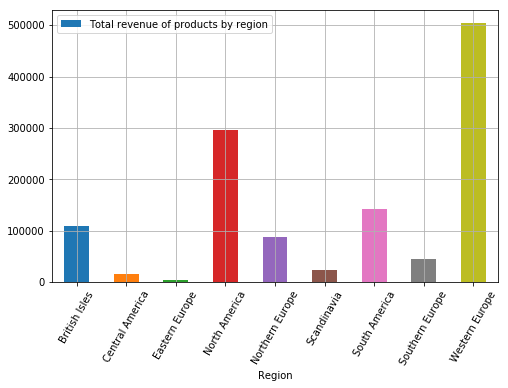

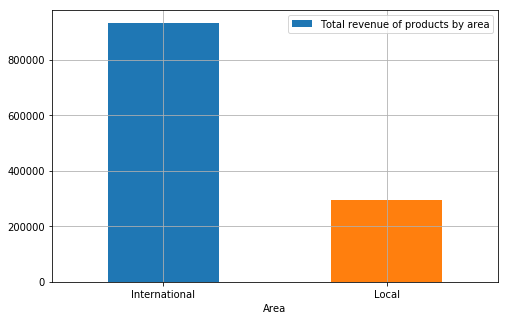

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
British Isles,190.0,573.427447,944.869689,4.80,144.7200,354.500,660.0000,9903.2
Central America,55.0,301.056364,539.362443,20.80,67.0750,196.800,366.0000,3952.5
Eastern Europe,16.0,220.746875,163.075679,22.35,107.5000,190.000,249.3750,591.6
North America,427.0,692.695317,1092.962510,14.00,147.9000,379.950,775.7375,10540.0
Northern Europe,143.0,609.483654,1073.633574,14.40,182.4375,300.000,606.0000,10540.0
Scandinavia,70.0,350.645750,353.425343,17.88,126.0000,259.875,445.5000,2108.0
South America,304.0,469.334895,979.863294,8.64,137.2875,288.750,524.7480,15810.0
Southern Europe,137.0,330.114726,387.244233,7.30,84.0000,207.000,443.7000,2475.8
Western Europe,736.0,684.169033,1018.954073,8.50,183.5375,416.120,811.5000,15019.5


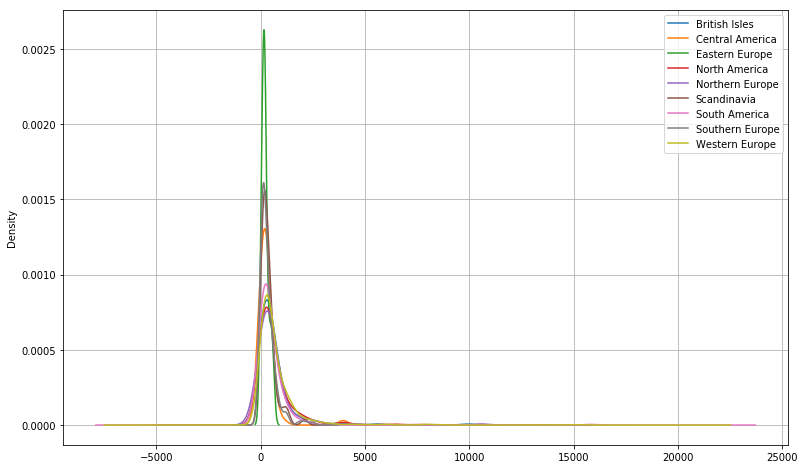

In [8]:
# Revenue by Region
plt.figure(figsize=(8,5))

df_region = df.groupby('Region')

#Bar graph of the sum quantity of the goods bought by region
df_region.Revenue.sum().plot(kind='bar', 
                             label='Total revenue of products by region', grid=True)
plt.xticks(rotation=60)
plt.legend()
plt.show()

# Revenue by Area
plt.figure(figsize=(8,5))

#Bar graph of the total revenue of goods bought by Area
df_area= df.groupby('Area')
df_area.Revenue.sum().plot(kind='bar', 
                           label='Total revenue of products by area', grid=True)
plt.xticks(rotation=0)
plt.legend()
plt.show()

#Print out the stats of Revenue/revenue
from IPython.core.display import HTML
display(HTML(df_region['Revenue'].describe().to_html())) 

#KDE plot of the sum quantity of goods
plt.figure(figsize=(13,8))
df_region.Revenue.plot(kind='kde', grid=True)
plt.legend()
plt.show()

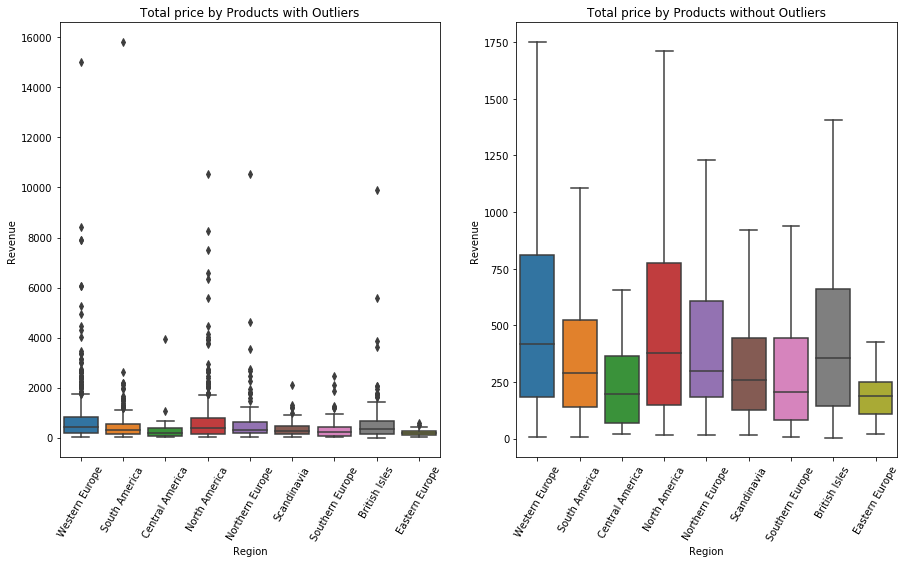

In [9]:
## Revenue with outliers ##

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15,8))
sns.boxplot(x='Region', y='Revenue', data=df, ax=ax1)
ax1.set_title(f'Total price by Products with Outliers')
ax1.tick_params(axis='x', labelrotation=60)

sns.boxplot(x='Region', y='Revenue', data=df, ax=ax2, showfliers=False)
ax2.set_title(f'Total price by Products without Outliers')
ax2.tick_params(axis='x', labelrotation=60)

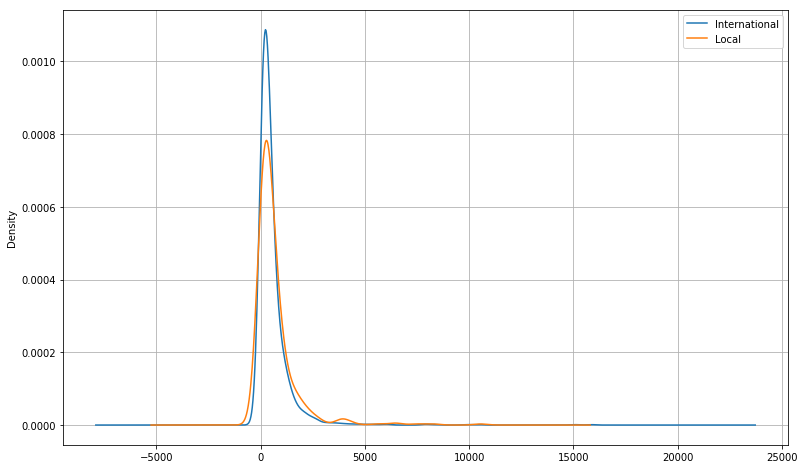

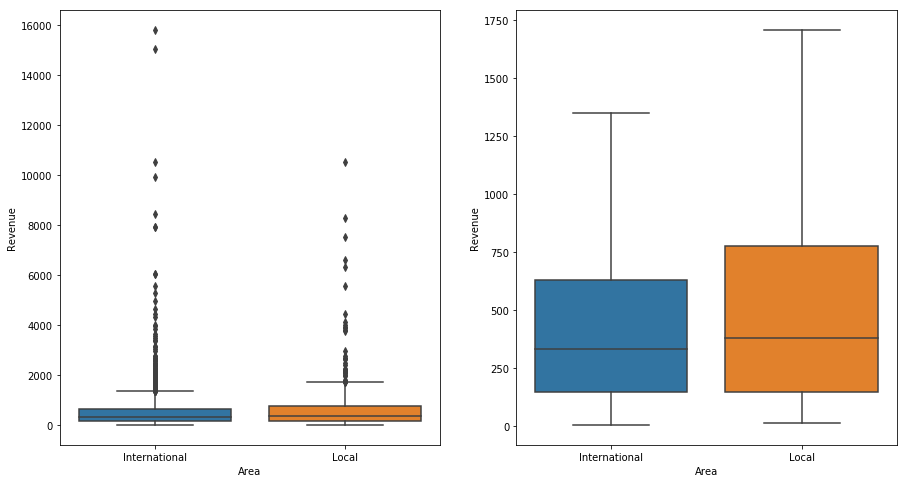

In [10]:
## Revenue of North America vs International Sales ##

# KDE of Area vs International Sales
plt.figure(figsize=(13,8))
df.groupby('Area').Revenue.plot(kind='kde', grid=True)
plt.legend()
plt.show()

#Barplot of Area vs International Sales with & without outliers
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,8))

sns.boxplot(x='Area', y='Revenue', data=df, showfliers=True, ax=ax1)
sns.boxplot(x='Area', y='Revenue', data=df, showfliers=False, ax=ax2)

plt.show()

## ANOVA and Tukey test on Revenue as the target

#### ANOVA

Here, we are using the ANOVA test to verify if there is a difference in variance amongst the revenue generated by region for the Northwind Company.

In [11]:
# ANOVA Test on region
alpha = 0.05

formula = f'Revenue ~ C(Region) + C(City) + C(Country) + C(Area)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm)
table['reject_null'] = table['PR(>F)'] < alpha
pd.DataFrame(table)

,df,sum_sq,mean_sq,F,PR(>F),reject_null
C(Region),8.0,3.559767e+07,4.449708e+06,4.902033,0.000005,True
C(City),68.0,1.203985e+08,1.770566e+06,1.950549,0.000008,True
C(Country),20.0,7.078310e+06,3.539155e+05,0.389892,0.993008,False
C(Area),1.0,1.131051e+06,1.131051e+06,1.246025,0.264447,False
Residual,2009.0,1.823624e+09,9.077272e+05,NaN,NaN,False


#### Tukey Comparison Test by Regions

In [12]:
# Set up the data for comparison (creates a specialised object)
MultiComp = MultiComparison(df.Revenue,df.Region)
result = MultiComp.tukeyhsd()
# Show all pair-wise comparisons:
# Print the comparisons
df_result = pd.DataFrame(data=result._results_table.data[1:], 
                         columns=result._results_table.data[0])
df_result

,group1,group2,meandiff,lower,upper,reject
0,British Isles,Central America,-272.3711,-732.8027,188.0605,False
1,British Isles,Eastern Europe,-352.6806,-1135.4558,430.0946,False
2,British Isles,North America,119.2679,-142.9680,381.5037,False
3,British Isles,Northern Europe,36.0562,-296.8467,368.9591,False
4,British Isles,Scandinavia,-222.7817,-643.2189,197.6555,False
5,British Isles,South America,-104.0926,-382.1856,174.0005,False
6,British Isles,Southern Europe,-243.3127,-580.3493,93.7239,False
7,British Isles,Western Europe,110.7416,-133.9562,355.4394,False
8,Central America,Eastern Europe,-80.3095,-934.4476,773.8286,False
9,Central America,North America,391.6390,-39.1539,822.4318,False


Look only at regions compared to North America 

In [13]:
df_result[((df_result.group1=='North America')|(df_result.group2=='North America'))]

,group1,group2,meandiff,lower,upper,reject
2,British Isles,North America,119.2679,-142.9680,381.5037,False
9,Central America,North America,391.6390,-39.1539,822.4318,False
15,Eastern Europe,North America,471.9484,-293.7684,1237.6653,False
21,North America,Northern Europe,-83.2117,-373.7448,207.3215,False
22,North America,Scandinavia,-342.0496,-729.8029,45.7037,False
23,North America,South America,-223.3604,-449.0171,2.2963,False
24,North America,Southern Europe,-362.5806,-657.8412,-67.3199,True
25,North America,Western Europe,-8.5263,-191.4531,174.4005,False


The results of our Tukey test suggests that the difference in sales of North America vs the other sales regions only appears when we compare North America to Southern Europe.

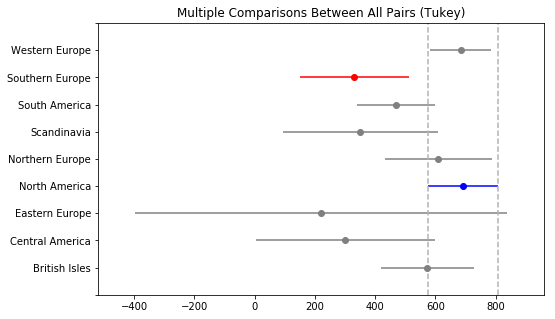

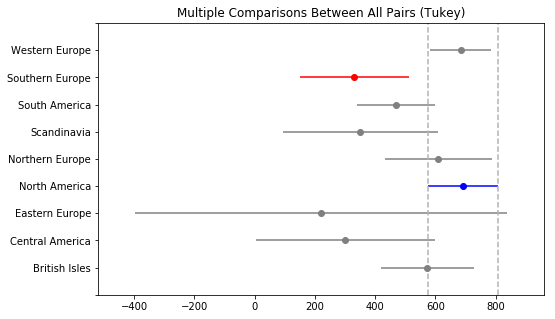

In [14]:
result.plot_simultaneous(comparison_name='North America', figsize=(8,5))

#### Tukey Test on total revenue of Area vs International sales as a whole

In [15]:
# Set up the data for comparison (creates a specialised object)
MultiComp = MultiComparison(df.Revenue,df.Area)
result = MultiComp.tukeyhsd()
# Show all pair-wise comparisons:
# Print the comparisons
df_result = pd.DataFrame(data=result._results_table.data[1:], 
                         columns=result._results_table.data[0])
df_result

,group1,group2,meandiff,lower,upper,reject
0,International,Local,128.0711,24.3394,231.8028,True


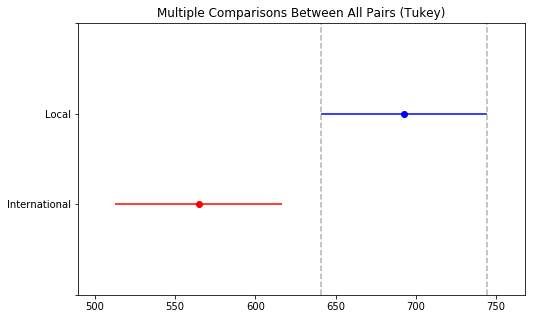

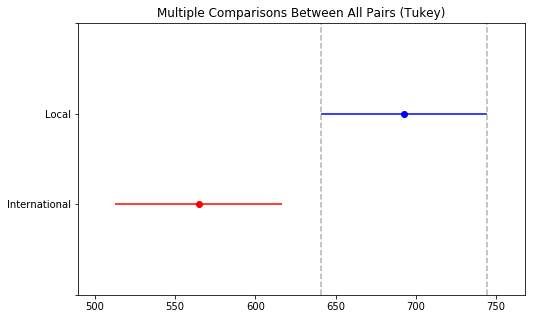

In [16]:
result.plot_simultaneous(comparison_name='Local', figsize=(8,5))

## Conclusion

Based on the results of our test, there is a significant difference in sales generated in foreign regions compared to North America, when we look at them region by regions(North America, Scadindavia, Western Europe, etc.)  This difference is its greatest when we compare North America to Southern Europe.  Besides this region, the others are not significant to note, although Eastern Europe takes a large span of space.

When we look at the difference between North America and International sales, there is a significant difference between the two, in favor of North America. **Therefore, we reject our null hypothesis.**